In [154]:
import torch
from torch import tensor
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from skimage import io, transform
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing
from typing import List
from IPython.display import clear_output

import sys
sys.path.insert(0, '/home/caitao/Project/dl-localization')
from input_output import Default
from utility import Utility

# Common modules

In [196]:
class MinMaxNormalize:
    '''Min max normalization, the new bound is (lower, upper)
    '''
    def __init__(self, lower=0, upper=1):
        assert isinstance(lower, (int, float))
        assert isinstance(upper, (int, float))
        self.lower = lower
        self.upper = upper

    def __call__(self, matrix):
        minn = matrix.min()
        maxx = matrix.max()
        matrix = (matrix - minn) / (maxx - minn)
        if self.lower != 0 or self.upper != 1:
            matrix = self.lower + matrix * (self.upper - self.lower)  # might have zero in the denominator
        return matrix.astype(np.float32)

class Metrics:
    '''Evaluation metrics
    '''
    @staticmethod
    def localization_error_regression(pred_batch, truth_batch, debug=False):
        '''euclidian error when modeling the output representation is a matrix (image)
           both pred and truth are batches, typically a batch of 32
        '''
        error = []
        for pred, truth in zip(pred_batch, truth_batch):
#             print(pred.shape, truth.shape)
#             pred_x, pred_y = pred[0], pred[1]
#             true_x, true_y = truth[0], truth[1]
#             err = Utility.distance((pred_x, pred_y), (true_x, true_y))
            error_row = []
            for i in range(0, len(pred), 2):
                one = pred[i:i+2] - truth[i:i+2]   # one pair of predicted location and ground truth
                error_row.append(np.sqrt(np.dot(one, one)))
            error.append(np.mean(error_row))
            if debug:
                print('pred', pred, 'truth', truth, 'err', error)
        return error

# 1 Regression -- output layer is a FC with two nodes

Note: don't use np.savetxt and np.loadtxt, use np.save and np.load instead. I/O in binary format is faster (almost 10x) than text format, and don't have the utf-8 encoding issue.

Assumption 1: Regression don't need that much data comparing to labeling. Because labeling needs labeled data on every cell, while regression don't. I.e. regression can lead to generalization on space. Am I talking about the labeling or segmentation here?

Assumption 2: Training sample increase linear with # TX, not exponential, with the CNN regression

In [22]:
# data
class SensorInputDatasetRegression(Dataset):
    '''Sensor reading input dataset
       Output is image, model as a image segmentation problem
    '''
    def __init__(self, root_dir: str, grid_len: int, transform=None):
        '''
        Args:
            root_dir:  directory with all the images
            labels:    labels of images
            transform: optional transform to be applied on a sample
        '''
        self.root_dir = root_dir
        self.transform = transform
        self.length = len(os.listdir(self.root_dir))
        self.sample_per_label = self.get_sample_per_label()
        self.grid_len = grid_len

    def __len__(self):
        return self.length * self.sample_per_label

    def __getitem__(self, idx):
        folder = int(idx/self.sample_per_label)
        folder = format(folder, '06d')
        matrix_name = str(idx%self.sample_per_label) + '.npy'
        target_name = str(idx%self.sample_per_label) + '.target.npy'
        matrix_path = os.path.join(self.root_dir, folder, matrix_name)
        matrix = np.load(matrix_path)
        if self.transform:
            matrix = self.transform(matrix)
        target_arr = self.get_regression_target(folder, target_name)
        target_arr = self.min_max_normalize(target_arr)
        sample = {'matrix':matrix, 'target':target_arr}
        return sample

    def get_sample_per_label(self):
        folder = glob.glob(os.path.join(self.root_dir, '*'))[0]
        samples = glob.glob(os.path.join(folder, '*.npy'))
        targets = glob.glob(os.path.join(folder, '*.target.npy'))
        return len(samples) - len(targets)

    def get_regression_target(self, folder: str, target_name: str):
        '''
        Args:
            folder: example of folder is 000001
        Return:
            a two dimension matrix
        '''
        target_file = os.path.join(self.root_dir, folder, target_name)
        target = np.load(target_file)
        target = np.reshape(target, -1)
        return target.astype(np.float32)

    def min_max_normalize(self, target_arr: np.ndarray):
        '''scale the localization to a range of (0, 1)
        '''
        target_arr /= self.grid_len
        return target_arr

    def undo_normalize(self, arr: np.ndarray):
        arr *= self.grid_len
        return arr


tf = T.Compose([
     MinMaxNormalize(),
     T.ToTensor()
])

# training
indx = 5
root_dir = './data/matrix-train30'
sensor_input_dataset = SensorInputDatasetRegression(root_dir = root_dir, grid_len = Default.grid_length, transform = tf)
sensor_input_dataloader = DataLoader(sensor_input_dataset, batch_size=32, shuffle=True, num_workers=3)
print(sensor_input_dataset[indx]['matrix'].shape)
print(sensor_input_dataset[indx]['target'])
print(sensor_input_dataset.__len__())

# testing
root_dir = './data/matrix-test30'
sensor_input_test_dataset = SensorInputDatasetRegression(root_dir = root_dir, grid_len = Default.grid_length, transform = tf)
sensor_input_test_dataloader = DataLoader(sensor_input_test_dataset, batch_size=32, shuffle=True, num_workers=3)
print(sensor_input_test_dataset[indx]['matrix'].shape)
print(sensor_input_test_dataset[indx]['target'])
print(sensor_input_test_dataset.__len__())

torch.Size([1, 100, 100])
[0.00752327 0.00389566 0.4644131  0.36409214]
100000
torch.Size([1, 100, 100])
[0.00969323 0.02633735 0.729036   0.64292115]
20000


In [23]:
class NetRegression1(nn.Module):
    '''the output of the fully connected layer is 1x2 array
       assume the input matrix is 1 x 100 x 100
    '''
    def __init__(self):
        super(NetRegression1, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.groupnorm1 = nn.GroupNorm(1, 8)
        self.groupnorm2 = nn.GroupNorm(1, 16)
        self.groupnorm3 = nn.GroupNorm(1, 32)
        self.fc1   = nn.Linear(2592, 100)
        self.fc2   = nn.Linear(100, 4)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.groupnorm1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.groupnorm2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.groupnorm3(self.conv3(x))), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

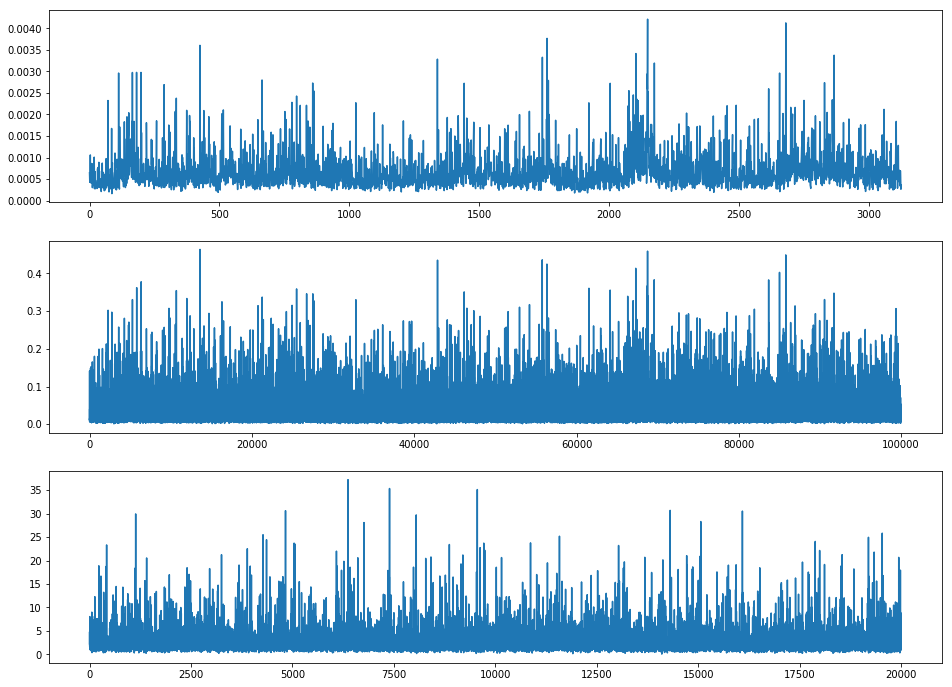

train loss mean = 0.0006742104239528999
train loss std  = 0.00043279614258471297
train mean = 0.026809344
train std  = 0.023521177
test mean = 2.7140667
test std  = 2.2374723
train loss
(0.00438061279008165, 0.014922643066419902)
(0.001538853914057836, 0.0007750978911558038)
(0.0012478235785756261, 0.0006815076219335995)
(0.0010819445472862572, 0.0006009875251376803)
(0.0009186646030470729, 0.0005239732471713088)
(0.0008394032406015321, 0.0004931189985881053)
(0.0008078080685948953, 0.0005112767081322685)
(0.0007021594480797649, 0.00043887983401363)
(0.0006935400054743513, 0.0004618547509708294)
(0.0006742104239528999, 0.00043279614258471297)
train error
(0.064380765, 0.06074203)
(0.04186811, 0.03356639)
(0.03718456, 0.03098717)
(0.034369417, 0.029223561)
(0.031623825, 0.027086109)
(0.030118251, 0.026026974)
(0.029335894, 0.025804104)
(0.02735489, 0.02404393)
(0.02703053, 0.024103185)
(0.026809344, 0.023521177)
test error
(4.2146134, 3.4662871)
(4.212099, 3.1012151)
(3.529112, 3.077401

In [199]:
# %%time
# training segmentation problem

NetRegression1 = NetRegression1()
print(NetRegression1)

device    = torch.device('cuda')
model     = NetRegression1.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # criterion is the loss function

num_epochs   = 10
train_losses_epoch = []
train_errors_epoch = []
test_errors_epoch  = []
best_acc = 0
print_every = 500

for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    train_losses = []
    train_errors = []
    test_errors  = []
    model.train()
    for t, sample in enumerate(sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        pred = model(X)
#         print('1\npred[0]', pred[0], '\n', 'y[0]', y[0], '\n')
#         do a matching here (don't think it will work), ordering the Truth labels might help
        pred, y = match(pred, y)
#         print('2\npred[0]', pred[0], '\n', 'y[0]', y[0], '\n')

        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        pred = pred.data.cpu()
        y = y.data.cpu()
        train_errors.extend(Metrics.localization_error_regression(pred, y))
        if t % print_every == 0:
            print(f't = {t}, loss = {loss.item()}')

    model.eval()
    for t, sample in enumerate(sensor_input_test_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        pred = model(X)
        pred, y = match(pred, y)
        pred = pred.data.cpu()
        y    = y.data.cpu()
        pred = sensor_input_dataset.undo_normalize(pred)
        y    = sensor_input_dataset.undo_normalize(y)
        test_errors.extend(Metrics.localization_error_regression(pred, y))

    clear_output(True)
    plt.figure(figsize=(16, 12))
    plt.subplot(311)
    plt.plot(train_losses)
    plt.subplot(312)
    plt.plot(train_errors)
    plt.subplot(313)
    plt.plot(test_errors)
    plt.show()

    print('train loss mean =', np.mean(train_losses))
    print('train loss std  =', np.std(train_losses))
    print('train mean =', np.mean(train_errors))
    print('train std  =', np.std(train_errors))    
    print('test mean =', np.mean(test_errors))
    print('test std  =', np.std(test_errors))
    train_losses_epoch.append((np.mean(train_losses), np.std(train_losses)))
    train_errors_epoch.append((np.mean(train_errors), np.std(train_errors)))
    test_errors_epoch.append((np.mean(test_errors), np.std(test_errors)))

print('train loss')
for loss in train_losses_epoch:
    print(loss)
print('train error')
for error in train_errors_epoch:
    print(error)
print('test error')
for error in test_errors_epoch:
    print(error)

In [176]:
def match(pred, y):
    '''
    Args:
        pred: Tensor -- (batch size, num tx * 2)
        y   : Tensor -- (batch size, num tx * 2)
    '''
    batch_size = len(pred)
    dimension  = len(pred[0])
    pred_m, y_m = torch.zeros((batch_size, dimension)), torch.zeros((batch_size, dimension))
    for i in range(batch_size):
        pred2, y2 = [], []   # for one sample
        for j in range(0, dimension, 2):
            pred2.append(pred[i][j:j+2])
            y2.append(y[i][j:j+2])
        pred2, y2 = match_helper(pred2, y2)
        pred_m[i] = pred2
        y_m[i]    = y2
    return pred_m, y_m
        
def match_helper(pred, y):
    ''' up to now, assume len(pred) and len(y) is equal
        do a matching of the predictions and truth
    Args:
        pred: list<Tensor<float>> -- pairs of locations
        y   : list<Tensor> -- pairs of locations
    Return:
        Tensor<float>, Tensor<float>
    '''
    distances = np.zeros((len(pred), len(y)))
    for i in range(len(pred)):
        for j in range(len(y)):
            distances[i, j] = Utility.distance(pred[i], y[j])

    matches = []
    k = 0
    while k < min(len(pred), len(y)):
        min_error = np.min(distances)
        min_error_index = np.argmin(distances)
        i = min_error_index // len(y)
        j = min_error_index % len(y)
        matches.append((i, j, min_error))
        distances[i, :] = np.inf
        distances[:, j] = np.inf
        k += 1

    pred_m, y_m = [], []
    for i, j, e in matches:
        pred_m.append(pred[i])
        y_m.append(y[j])

    return torch.cat(pred_m), torch.cat(y_m)

In [8]:
def myplot(X, y, pred):
    X = X[0][0]
    y = y[0].reshape(2, 2)
    pred = pred[0].reshape(2, 2)
    grid_y = np.zeros((len(X), len(X)))
    grid_pred = np.zeros((len(X), len(X)))
    print('Truth')
    for loc in y:
        print(loc)
        grid_y[int(loc[0])][int(loc[1])] = 1
        grid_y[int(loc[0])][int(loc[1])] = 1
    print('Prediction')
    for loc in pred:
        print(loc)
        grid_pred[int(loc[0])][int(loc[1])] = 1
        grid_pred[int(loc[0])][int(loc[1])] = 1
    fig, ax = plt.subplots(1, 3, figsize=(30, 10))
    ax[0].imshow(X, cmap='gray')
    ax[1].imshow(grid_y, cmap='gray')
    ax[2].imshow(grid_pred, cmap='gray')

loss type <class 'torch.Tensor'>
loss 0.018486684 error 2.1904855 std 1.2230886
Truth
[56.50807   9.175851]
[58.291306 94.00244 ]
Prediction
[56.393467  9.3658  ]
[58.146584 92.44984 ]


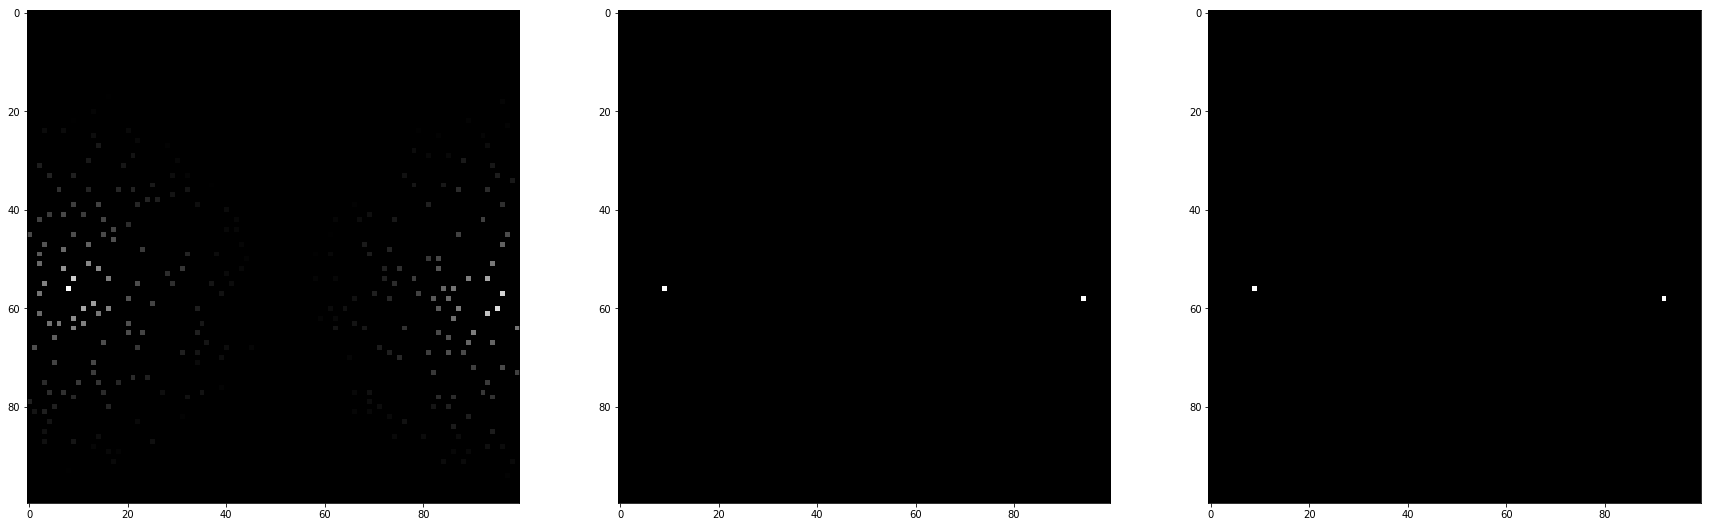

In [201]:
model.eval()
for t, sample in enumerate(sensor_input_test_dataloader):
    X = sample['matrix'].to(device)
    y = sample['target'].to(device)
    pred = model(X)
    pred, y = match(pred, y)
    
#     pred = pred[0].unsqueeze(0)
#     X    = X[0].unsqueeze(0)
#     y    = y[0].unsqueeze(0)
    loss = torch.sqrt(criterion(pred, y))
    print('loss type', type(loss))
    loss = loss.data.cpu().numpy()
    X    = X.data.cpu().numpy()
    pred = pred.data.cpu().numpy()
    y    = y.data.cpu().numpy()
    pred = sensor_input_dataset.undo_normalize(pred)
    y    = sensor_input_dataset.undo_normalize(y)
    errors = Metrics.localization_error_regression(pred, y, False)
    print('loss', loss, 'error', np.mean(errors), 'std', np.std(errors))
    myplot(X, y, pred)
    break

loss type <class 'torch.Tensor'>
loss 0.1871697 error 350.32495108246803 std 265.5929585012419
Truth
[28.154015 85.58557 ]
[64.86874  61.964077]
Prediction
[44.65046 73.17798]
[48.587875 73.91853 ]


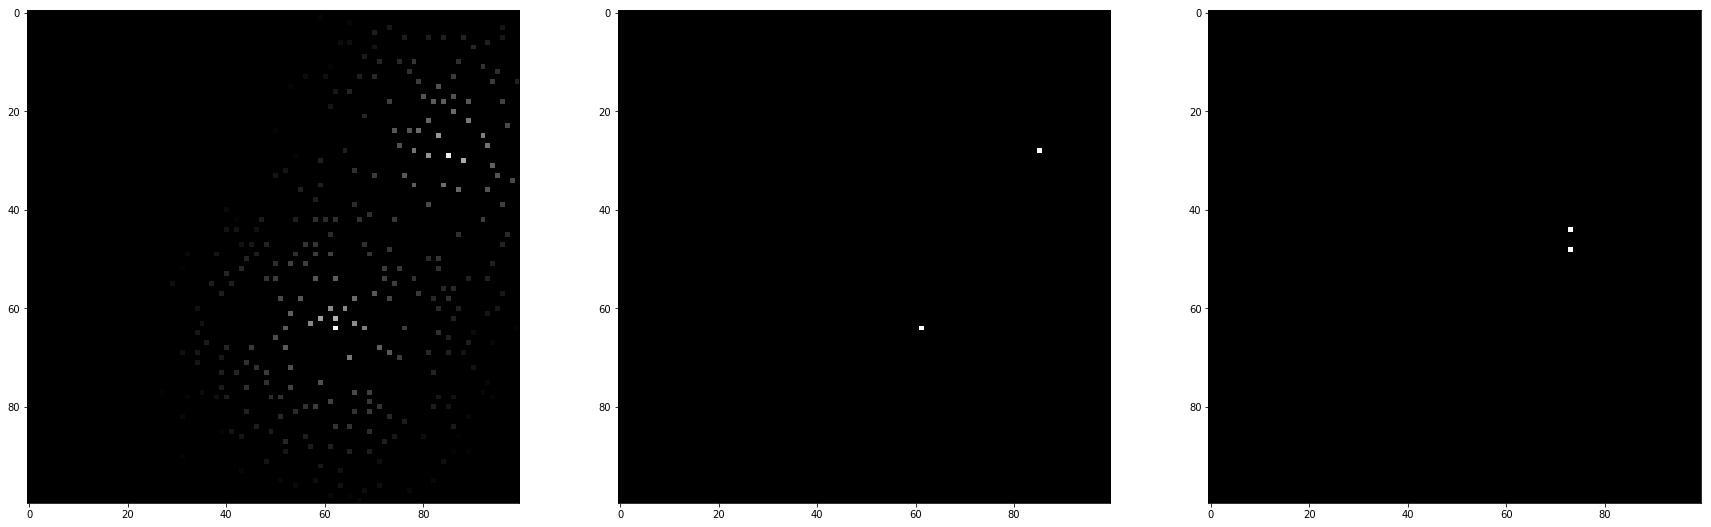

In [114]:
model.eval()
for t, sample in enumerate(sensor_input_test_dataloader):
    X = sample['matrix'].to(device)
    y = sample['target'].to(device)
    pred = model(X)
#     pred = pred[0].unsqueeze(0)
#     X    = X[0].unsqueeze(0)
#     y    = y[0].unsqueeze(0)
    loss = torch.sqrt(criterion(pred, y))
    print('loss type', type(loss))
    loss = loss.data.cpu().numpy()
    X    = X.data.cpu().numpy()
    pred = pred.data.cpu().numpy()
    y    = y.data.cpu().numpy()
    pred = sensor_input_dataset.undo_normalize(pred)
    y    = sensor_input_dataset.undo_normalize(y)
    errors = Metrics.localization_error_regression(pred, y, False)
    print('loss', loss, 'error', np.mean(errors), 'std', np.std(errors))
    myplot(X, y, pred)
    break